# Notebook for k selection

This notebook report an exploratory data analysis to get the best k-value

In [77]:
import os
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_API_KEY")
MODEL_NAME = "gpt-3.5-turbo-0125"  # will change it :)

## Loading data

In [78]:
db = FAISS.load_local("../db/index_summary/", OpenAIEmbeddings(), allow_dangerous_deserialization=True)

In [79]:
db.index.ntotal

1174

In [80]:
df = pd.read_csv("../simulated_data/mentor_student_cvs_with_summaries_final.csv")
df.columns

Index(['Mentor Profile', 'Mock Student CV', 'PDF Text', 'Mentor_Summary',
       'Mentee_Summary'],
      dtype='object')

In [81]:
print(df['Mentee_Summary'][0])

Johnathan A. Doe is a graduate of Houston University where he obtained his Bachelor's Science in Biology. He served as a Research Assistant in the Department of Pathology of the same university, where he displayed exceptional expertise in molecular biology and microbiota studies. Particularly, Doe has made significant contributions in microbial culture research.

During his tenure, Doe has conducted experiments on bacterial culture pH readouts using UV-Vis absorption spectrophotometry, showcasing his skills in Molecular & Cellular Biology Techniques as well as data analysis using statistical software like R and SPSS. His research has resulted in notable publications such as "Analyzing Microbial Culture pH through UV-Vis Absorption Spectrophotometry," "Effectiveness of Molecular Models in Understanding Protein-Ligand Interactions," and "Investigating the Role of Microbiota on Human Immune Responses." 

More than his research profile, Doe is actively involved in community health activiti

## Example of FAISS similarity query

In [82]:
db.similarity_search_with_score(df['Mentee_Summary'][0], k=20)

[(Document(page_content="8183325.pdf\n=====\nAnthony Haag is an Assistant Professor at Baylor College of Medicine, working within the Department of Pathology & Immunology. His main research interests encompass the areas of Tandem Mass Spectrometry, Liquid Chromatography, Gastrointestinal Microbiome, and Sterilization, among others. Some of his notable achievements and significant contributions to the scientific community are evident in his numerous published research papers. His work revolves around the exploration of the gut-brain axis using various LC-MS/MS-based targeted metabolomics, as well as the investigation of the mammalian gut microbiome and its influence on various physiological functions. Haag's research also includes the study of neurotransmitter profiles and their alterations in relation to the presence of specific microbiota such as Bifidobacterium dentium. His work is widely cited and discussed, reflecting its relevance and impact in the field of Pathology and Immunolog

## Running similarity search for the analysis 

In [83]:
sim_res = [db.similarity_search_with_score(mentee_cv, k=df.shape[0], fetch_k=df.shape[0]) for mentee_cv in tqdm(df['Mentee_Summary'].values)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1174/1174 [03:05<00:00,  6.32it/s]


In [84]:
res_acc = []
for k in range(1,201):
    search_sucessful = []
    rankings = []
    for i, sim in enumerate(sim_res):
        ground_truth = df["Mentor Profile"][i]

        found = False
        for rnk, res in enumerate(sim[:k]):
            res_mentor_id = res[0].page_content.split("=====")[0].strip()
            if ground_truth in res_mentor_id:
                found = True
                rankings.append(rnk+1)
                break
        search_sucessful.append(found)

    accuracy = sum(search_sucessful) / len(search_sucessful)
    avg_rank = sum(rankings) / len(rankings)
    res_acc.append({"k": k,  "accuracy": accuracy, "hits": sum(search_sucessful), "avg_rank": avg_rank})

In [85]:
pd_res = pd.DataFrame(res_acc)
pd_res.tail()

,k,accuracy,hits,avg_rank
195,196,0.940375,1104,17.593297
196,197,0.940375,1104,17.593297
197,198,0.940375,1104,17.593297
198,199,0.941227,1105,17.757466
199,200,0.941227,1105,17.757466


## top-K Accuracy

<Axes: xlabel='k', ylabel='accuracy'>

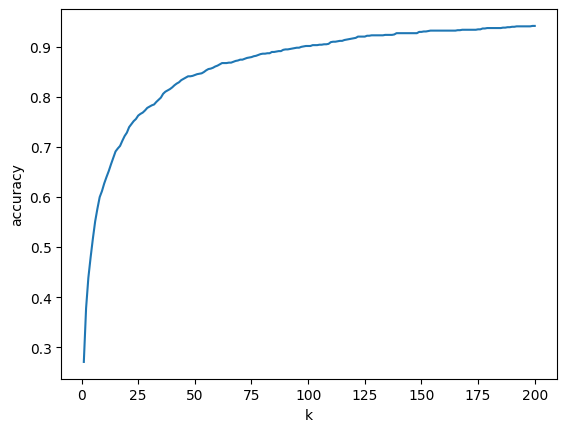

In [86]:
sns.lineplot(x='k', y='accuracy', data=pd_res)

In [87]:
search_sucessful = []
rankings = []
for i, sim in enumerate(sim_res):
    ground_truth = df["Mentor Profile"][i]

    found = False
    for rnk, res in enumerate(sim):
        res_mentor_id = res[0].page_content.split("=====")[0].strip()
        if ground_truth in res_mentor_id:
            found = True
            rankings.append(rnk+1)
            break

## simiarity rank distrubtion

The visualizations of the rank could guide us choosing a reasonable k, and the cummulative plot show that $k = 36$ might be a resonable choice to get a decent accuracy for candidate selection, but with lower candidate selection. i.e., greater $k$ will make the final selection harder.

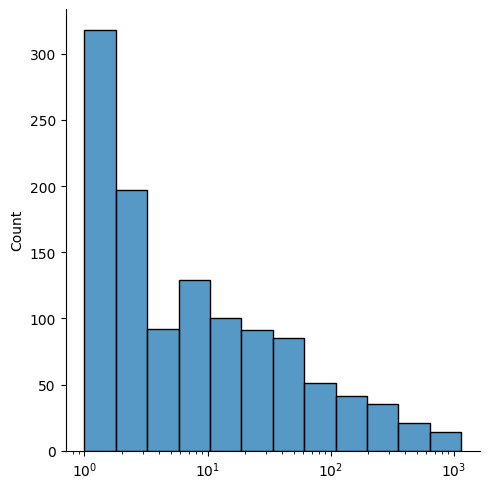

In [88]:
sns.displot(np.array(rankings), log_scale=True)

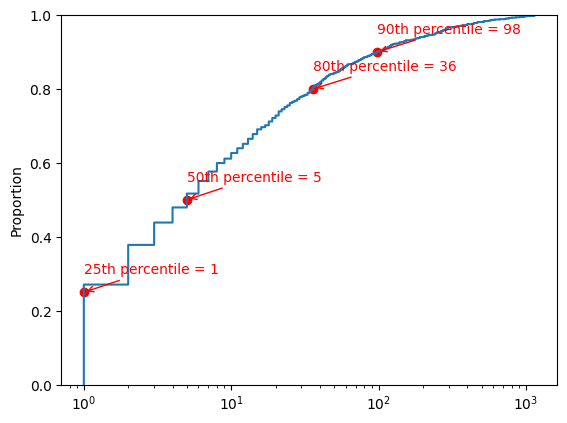

In [89]:
sns.ecdfplot(np.array(rankings), log_scale=True)

# Calculate desired percentiles
percentiles = [25, 50, 80, 90]
percentile_values = np.percentile(rankings, percentiles)

# Add points for the specified percentiles
for percentile, value in zip(percentiles, percentile_values):
    plt.scatter(value, percentile / 100, color='red', label=f'{percentile}th percentile')
    plt.annotate(f'{percentile}th percentile = {value:.0f}', 
                 xy=(value, percentile / 100), 
                 xytext=(value, (percentile / 100) + 0.05),  # Position the text slightly above the point
                 arrowprops=dict(arrowstyle='->', color='red'), 
                 color='red')
